# An Introduction to Factorization Machines with MNIST
_**Making a Binary Prediction of Whether a Handwritten Digit is a 0**_

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Data ingestion](#Data-ingestion)
  3. [Data inspection](#Data-inspection)
  4. [Data conversion](#Data-conversion)
3. [Training the FM model](#Training-the-FM-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
  1. [Import model into hosting](#Import-model-into-hosting)
  2. [Create endpoint configuration](#Create-endpoint-configuration)
  3. [Create endpoint](#Create-endpoint)
5. [Validate the model for use](#Validate-the-model-for-use)

1. [はじめに]（＃はじめに）
2. [前提条件と前処理]（＃前提条件と前処理）
   1. [パーミッションと環境変数]（＃パーミッションと環境変数）
   2. [データの取り込み]（＃データの取り込み）
   3. [データ検査]（＃データ検査）
   4. [データ変換]（＃データ変換）
3. [FMモデルのトレーニング]（＃Training-the-FMモデル）
4. [モデルのホスティングを設定する]（＃Set-up-the-model）
   1. [モデルをホスティングにインポート]（＃インポートモデル - ホスティング）
   2. [エンドポイント構成の作成]（＃Create-endpoint-configuration）
   3. [エンドポイントの作成]（＃Create-endpoint）
5. [使用するモデルの検証]（＃使用するモデルの検証）


## Introduction

Welcome to our example introducing Amazon SageMaker's Factorization Machines Algorithm!  Today, we're analyzing the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset which consists of images of handwritten digits, from zero to nine.  We'll use the individual pixel values from each 28 x 28 grayscale image to predict a yes or no label of whether the digit is a 0 or some other digit (1, 2, 3, ... 9).

The method that we'll use is a factorization machine binary classifier.  A factorization machine is a general-purpose supervised learning algorithm that you which can use for both classification and regression tasks.  It is an extension of a linear model that is designed to parsimoniously capture interactions between features in high dimensional sparse datasets.  For example, in a click prediction system, the factorization machine model can capture click rate patterns observed when ads from a certain ad-category are placed on pages from a certain page-category.  Factorization machines are a good choice for tasks dealing with high dimensional sparse datasets, such as click prediction and item recommendation.

Amazon SageMaker's Factorization Machine algorithm provides a robust, highly scalable implementation of this algorithm, which has become extremely popular in ad click prediction and recommender systems.  The main purpose of this notebook is to quickly show the basics of implementing Amazon SageMaker Factorization Machines, even if the use case of predicting a digit from an image is not where factorization machines shine.

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

---
## はじめに
Amazon SageMakerのFactorization Machinesアルゴリズムの導入例へようこそ！今日、私たちは、0から9までの手書き数字の画像で構成される[MNIST]（https://en.wikipedia.org/wiki/MNIST_database）データセットを分析しています。各28×28グレースケール画像の個々のピクセル値を使用して、数字が0か別の数字（1,2,3、... 9）かどうかのはい/いいえのラベルを予測します。

私たちが使用する方法は、分解マシンバイナリ分類器です。因数分解装置は、分類作業と回帰作業の両方に使用できる汎用の監視学習アルゴリズムです。これは、高次元の疎なデータセット内のフィーチャ間の相互作用を間違いなくキャプチャするように設計された線形モデルの拡張です。例えば、クリック予測システムでは、因数分解機械モデルは、ある広告カテゴリの広告が特定のページカテゴリのページに配置されたときに観察されるクリック率パターンを取得することができる。ファクトリゼーションマシンは、クリック予測やアイテムの推奨など、高次元の疎なデータセットを扱うタスクに適しています。

Amazon SageMakerのFactorization Machineアルゴリズムは、このアルゴリズムの堅牢でスケーラブルな実装を提供します。このアルゴリズムは、広告のクリック予測や推薦システムで非常に人気が高くなっています。このノートブックの主な目的は、画像から数字を予測するユースケースが分解マシンが輝く場所ではなくても、Amazon SageMaker分解マシンの実装の基礎を素早く示すことです。

まず、権限、構成など、いくつかの前提条件を設定して環境をセットアップする必要があります。

## Prequisites and Preprocessing

### Permissions and environment variables

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

---
## 前提条件と前処理
### パーミッションと環境変数

_このノートブックは、ml.m4.xlargeノートブック・インスタンスで作成およびテストされました。

以下を指定して始めましょう。

- トレーニングとモデルデータに使用するS3バケットとプレフィックス。 これは、ノートブックインスタンス、トレーニング、およびホスティングと同じ領域内にある必要があります。
- IAMの役割は、トレーニングを行い、データへのアクセスをホストするために使用されます。 これらを作成する方法については、ドキュメントを参照してください。 ノートブックインスタンス、トレーニング、および/またはホスティングに複数の役割が必要な場合は、boto regexpを適切な完全IAMロールのarn文字列に置き換えてください。

In [1]:
bucket = 'sagemaker-shokout'
prefix = 'sagemaker/DEMO-fm-mnist'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


### Data ingestion

Next, we read the dataset from an online URL into memory, for preprocessing prior to training. This processing could be done *in situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.

---

### データ摂取

次に、訓練の前に前処理のために、オンラインURLからデータセットをメモリに読み込みます。 この処理は、Amazon Athena、Amazon EMRのApache Spark、Amazon Redshiftなどで、インサイツ*で行うことができます。データセットが適切な場所にあると仮定します。 次に、トレーニングに使用するためにデータをS3に転送することです。 このような小さなデータセットの場合、メモリへの読み込みは大規模ではありませんが、大規模なデータセットの場合はそうです。

In [2]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 1.01 s, sys: 323 ms, total: 1.34 s
Wall time: 2.76 s


### Data inspection

Once the dataset is imported, it's typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed. You can perform those tasks right here in the notebook. As an example, let's go ahead and look at one of the digits that is part of the dataset.

### データ検査

データセットをインポートすると、データを検査し、その分布を理解し、必要な事前処理のタイプを判断するために、マシン学習プロセスの一部として典型的です。 これらのタスクはノートブックですぐに実行できます。 例として、データセットの一部である数字の1つを見てみましょう。

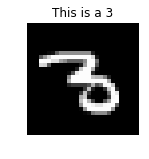

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

### Data conversion

Since algorithms have particular input and output requirements, converting the dataset is also part of the process that a data scientist goes through prior to initiating training. In this particular case, the Amazon SageMaker implementation of Factorization Machines takes recordIO-wrapped protobuf, where the data we have today is a pickle-ized numpy array on disk.

Most of the conversion effort is handled by the Amazon SageMaker Python SDK, imported as `sagemaker` below.

_Notice, despite the fact that most use cases for factorization machines will utilize spare input, we are writing our data out as dense tensors.  This will be fine since the MNIST dataset is not particularly large or high dimensional._

---

### データ変換

アルゴリズムには特定の入出力要件があるため、データセットを変換することは、データ科学者がトレーニングを開始する前に行うプロセスの一部でもあります。 この特定のケースでは、ファクトライゼーションマシンのAmazon SageMaker実装ではrecordIO-wrapped protobufが使用されます。今日のデータは、ディスク上のpickle-numedアレイです。

ほとんどの変換作業はAmazon SageMaker Python SDKによって処理され、以下の `sagemaker 'としてインポートされます。

（注意）因子分解マシンのほとんどのユースケースがスペア入力を利用するという事実にもかかわらず、私たちは密なテンソルとしてデータを書き出しています。 これは、MNISTデータセットが特に大きかったり大きかったりしなかったのでうまくいくでしょう。

In [4]:
import io
import numpy as np
import sagemaker.amazon.common as smac

vectors = np.array([t.tolist() for t in train_set[0]]).astype('float32')
labels = np.where(np.array([t.tolist() for t in train_set[1]]) == 0, 1.0, 0.0).astype('float32')

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

0

## Upload training data
Now that we've created our recordIO-wrapped protobuf, we'll need to upload it to S3, so that Amazon SageMaker training can use it.

## トレーニングデータをアップロードする
recordIOラップされたprotobufを作成したので、S3にアップロードしてAmazon SageMakerのトレーニングで使用できるようにする必要があります。

In [5]:
import boto3
import os

key = 'recordio-pb-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker-shokout/sagemaker/DEMO-fm-mnist/train/recordio-pb-data


Let's also setup an output S3 location for the model artifact that will be output as the result of training with the algorithm.

また、アルゴリズムを使ったトレーニングの結果として出力されるモデル成果物の出力S3の位置を設定してみましょう。


In [6]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://sagemaker-shokout/sagemaker/DEMO-fm-mnist/output


## Training the factorization machine model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. Since this data is relatively small, it isn't meant to show off the performance of the Amazon SageMaker's Factorization Machines in training, although we have tested it on multi-terabyte datasets.

Again, we'll use the Amazon SageMaker Python SDK to kick off training and monitor status until it is completed.  In this example that takes between 7 and 11 minutes.  Despite the dataset being small, provisioning hardware and loading the algorithm container take time upfront.

First, let's specify our containers.  Since we want this notebook to run in all 4 of Amazon SageMaker's regions, we'll create a small lookup.  More details on algorithm containers can be found in [AWS documentation](https://docs-aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).

## 因子分解モデルのトレーニング

データを前処理し、トレーニング用の正しいフォーマットで利用できるようになると、次のステップはデータを使用して実際にモデルをトレーニングすることです。 このデータは比較的小さいので、Amazon SageMakerのファクタライゼーションマシンのトレーニングでのパフォーマンスを示すことを目的としたものではありませんが、数テラバイトのデータセットでテストしています。

また、Amazon SageMaker Python SDKを使用してトレーニングを開始し、完了するまでステータスを監視します。 この例では、7〜11分かかります。 データセットが小さくても、ハードウェアのプロビジョニングとアルゴリズムコンテナのロードには時間がかかります。

まず、コンテナを指定しましょう。 Amazon SageMakerの4つの地域すべてでこのノートブックを実行したいので、小さなルックアップを作成します。 アルゴリズムコンテナの詳細については、[AWS documentation]（https://docs-aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html）を参照してください。

In [7]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'factorization-machines')

Next we'll kick off the base estimator, making sure to pass in the necessary hyperparameters.  Notice:
- `feature_dim` is set to 784, which is the number of pixels in each 28 x 28 image.
- `predictor_type` is set to 'binary_classifier' since we are trying to predict whether the image is or is not a 0.
- `mini_batch_size` is set to 200.  This value can be tuned for relatively minor improvements in fit and speed, but selecting a reasonable value relative to the dataset is appropriate in most cases.
- `num_factors` is set to 10.  As mentioned initially, factorization machines find a lower dimensional representation of the interactions for all features.  Making this value smaller provides a more parsimonious model, closer to a linear model, but may sacrifice information about interactions.  Making it larger provides a higher-dimensional representation of feature interactions, but adds computational complexity and can lead to overfitting.  In a practical application, time should be invested to tune this parameter to the appropriate value.

---

次に、必要なハイパーパラメータを確実に渡して、ベースエスティメータを開始します。通知：
- `feature_dim`は784に設定され、これは各28 x 28画像のピクセル数です。
- `predictor_type`は 'binary_classifier'に設定されています。画像が0であるかどうかを予測しようとしているからです。
- `mini_batch_size`は200に設定されています。この値はフィットとスピードの比較的小さな改善のために調整できますが、ほとんどの場合、データセットに対して妥当な値を選択するのが適切です。
- `num_factors`は10に設定されます。最初に述べたように、分解マシンはすべてのフィーチャのインタラクションのより低い次元表現を見つけます。この値を小さくすると、線形モデルに近いより簡潔なモデルが得られますが、相互作用に関する情報は犠牲になります。それを大きくすると、フィーチャのインタラクションの高次元表現が提供されますが、計算の複雑さが増し、オーバーフィットにつながる可能性があります。実際のアプリケーションでは、このパラメータを適切な値に調整するために時間を費やす必要があります。

In [9]:
import boto3
import sagemaker

sess = sagemaker.Session()

fm = sagemaker.estimator.Estimator(container,
                                   role, 
                                   train_instance_count=1, 
                                   train_instance_type='ml.c4.xlarge',
                                   output_path=output_location,
                                   sagemaker_session=sess)
fm.set_hyperparameters(feature_dim=784,
                      predictor_type='binary_classifier',
                      mini_batch_size=200,
                      num_factors=10)

fm.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: factorization-machines-2018-10-16-16-14-35-986


2018-10-16 16:14:36 Starting - Starting the training job...
Launching requested ML instances...
Preparing the instances for training......
2018-10-16 16:17:12 Downloading - Downloading input data
2018-10-16 16:17:30 Training - Training image download completed. Training in progress..
Docker entrypoint called with argument(s): train
[10/16/2018 16:17:35 INFO 140382695880512] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'factors_lr': u'0.0001', u'linear_init_sigma': u'0.01', u'epochs': 1, u'_wd': u'1.0', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'factors_init_sigma': u'0.001', u'_log_level': u'info', u'bias_init_method': u'normal', u'linear_init_method': u'normal', u'linear_lr': u'0.001', u'factors_init_method': u'normal', u'_tuning_objective_metric': u'', u'bias_wd': u'0.01', u'use_linear': u'true', u'bias_lr': u'0.1', u'mini_batch_size': u'1000', u'_use_full_symbolic': u'true', u'batch_metrics_publish_inte

Billable seconds: 34


## Set up hosting for the model
Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint.  This will allow out to make predictions (or inference) from the model dyanamically.

_Note, Amazon SageMaker allows you the flexibility of importing models trained elsewhere, as well as the choice of not importing models if the target of model creation is AWS Lambda, AWS Greengrass, Amazon Redshift, Amazon Athena, or other deployment target._

---

## モデルのホスティングを設定する
モデルを訓練したので、Amazon SageMakerのリアルタイムホストエンドポイントの後ろに配置することができます。 これにより、モデルからの予測が不正に行われることがあります。

Amazon SageMakerでは、モデル作成の対象がAWS Lambda、AWS Greengrass、Amazon Redshift、Amazon Athena、その他のデプロイメントターゲットであれば、モデルをインポートしないよう選択するだけでなく、他の場所で訓練されたモデルをインポートする柔軟性が得られます。


In [10]:
fm_predictor = fm.deploy(initial_instance_count=1,
                         instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: factorization-machines-2018-10-16-16-19-36-305
INFO:sagemaker:Creating endpoint with name factorization-machines-2018-10-16-16-14-35-986


----------------------------------------------------------------!

## Validate the model for use
Finally, we can now validate the model for use.  We can pass HTTP POST requests to the endpoint to get back predictions.  To make this easier, we'll again use the Amazon SageMaker Python SDK and specify how to serialize requests and deserialize responses that are specific to the algorithm.

Since factorization machines are so frequently used with sparse data, making inference requests with a CSV format (as is done in other algorithm examples) can be massively inefficient.  Rather than waste space and time generating all of those zeros, to pad the row to the correct dimensionality, JSON can be used more efficiently.  Since we trained the model using dense data, this is a bit of a moot point, as we'll have to pass all the 0s in anyway.

Nevertheless, we'll write our own small function to serialize our inference request in the JSON format that Amazon SageMaker Factorization Machines expects.

---

## 使用するためにモデルを検証する
最後に、モデルを使用するために検証することができます。 エンドポイントにHTTP POST要求を渡すことで、予測を取り戻すことができます。 これを簡単にするために、Amazon SageMaker Python SDKを再度使用して、リクエストにシリアル化する方法と、アルゴリズムに固有のレスポンスを逆シリアル化する方法を指定します。

Factorization Machineはスパースなデータで頻繁に使用されるので、（他のアルゴリズムの例で行われているように）CSV形式で推論要求を行うことは大いに非効率的である可能性があります。 スペースと時間を無駄にするのではなく、それらのゼロをすべて生成し、行を正しい次元に埋め込むために、JSONをより効率的に使用することができます。 私たちは密度の高いデータを使用してモデルを訓練してきたので、これはちょっとした問題です。なぜなら、とにかくすべての0を渡す必要があるからです。

それにもかかわらず、私たちはAmazon SageMaker Factorization Machinesが期待するJSON形式で推論リクエストをシリアライズする独自の小さな関数を作成します。

In [11]:
import json
from sagemaker.predictor import json_deserializer

def fm_serializer(data):
    js = {'instances': []}
    for row in data:
        js['instances'].append({'features': row.tolist()})
    return json.dumps(js)

fm_predictor.content_type = 'application/json'
fm_predictor.serializer = fm_serializer
fm_predictor.deserializer = json_deserializer

Now let's try getting a prediction for a single record.

次に、1つのレコードの予測を試してみましょう。

In [13]:
result = fm_predictor.predict(train_set[0][30:31])
print(result)

{'predictions': [{'score': 0.0, 'predicted_label': 0.0}]}


OK, a single prediction works.  We see that for one record our endpoint returned some JSON which contains `predictions`, including the `score` and `predicted_label`.  In this case, `score` will be a continuous value between [0, 1] representing the probability we think the digit is a 0 or not.  `predicted_label` will take a value of either `0` or `1` where (somewhat counterintuitively) `1` denotes that we predict the image is a 0, while `0` denotes that we are predicting the image is not of a 0.

Let's do a whole batch of images and evaluate our predictive accuracy.

---

OK、単一の予測が機能します。 1つのレコードに対して、エンドポイントは `score`と` predicted_label`を含む `predictions`を含むJSONをいくつか返しました。 この場合、「スコア」は、数字が0であると思われる確率を表す[0、1]の間の連続値になります。 `predicted_label`は` 0`または `1`の値をとるでしょう。（やや直感的に）` 1`は画像が0であることを意味し、 `0`は画像が0でないと予測していることを意味します 。

一括して画像を作成し、予測精度を評価しましょう。

In [14]:
import numpy as np

predictions = []
for array in np.array_split(test_set[0], 100):
    result = fm_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)

In [15]:
import pandas as pd

pd.crosstab(np.where(test_set[1] == 0, 1, 0), predictions, rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0,8855,165
1,29,951


As we can see from the confusion matrix above, we predict 951 images of the digit 0 correctly (confusingly this is class 1).  Meanwhile we predict 165 images as the digit 0 when in actuality they aren't, and we miss predicting 29 images of the digit 0 that we should have.

*Note: Due to some differences in parameter initialization, your results may differ from those listed above, but should remain reasonably consistent.*

---
上記の混乱行列からわかるように、数字0の951個の画像を正しく予測します（これはクラス1です）。 一方、我々は、実際にはそうでない場合、数字0として165画像を予測し、数字0の29画像を予測しない。

*注：パラメータの初期化の違いにより、上記の結果と異なる場合がありますが、合理的な一貫性を保つ必要があります。

### (Optional) Delete the Endpoint

If you're ready to be done with this notebook, please run the delete_endpoint line in the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

---

### （オプション）エンドポイントを削除する

このノートブックで作業する準備ができたら、下のセルでdelete_endpoint行を実行してください。 これにより、作成したホストされたエンドポイントが削除され、放置されているインスタンスからの料金は請求されません。

In [ ]:
import sagemaker

sagemaker.Session().delete_endpoint(fm_predictor.endpoint)